<a href="https://colab.research.google.com/github/aniketmishr/NeuralNetwork/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline

np.random.seed(1)

In [2]:
def get_dataset(dataset):
  # Datasets
  noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()
  datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}
  X, Y = datasets[dataset]
  X, Y = X.T, Y.reshape(1, Y.shape[0])
  # make blobs binary
  if dataset == "blobs":
    Y = Y%2
  # Visualize the data
  plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
  return X,Y

In [3]:
def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


In [4]:
class NeuralNetwork:
  def __init__(self,n_l,lr,g,epochs):
    self.n_l = n_l
    self.L = len(n_l)
    self.lr = lr
    self.g, self.d_g = self.get_activation(g)
    self.epochs = epochs

    self.X = None
    self.y = None
    self.w = None
    self.b = None
    self.Z= [None]*self.L
    self.A = [None]*self.L
    self.dA = [None]*self.L
    self.dz = [None]*self.L
    self.dw = [None]*self.L
    self.db = [None]*self.L
    self.cost = []

  def get_activation(self,g):
    gx = [] #activation fucntions
    d_gx = [] # derivative of activation fucntions
    for s in g:
      if s=="tanh":
        gx.append(self.tanh)
        d_gx.append(self.d_tanh)
      elif s=="sigmoid":
        gx.append(self.sigmoid)
        d_gx.append(self.d_sigmoid)
      elif s=="relu":
         gx.append(self.relu)
         d_gx.append(self.d_relu)
      else:
        print("Invalid Acivation function")
        return None
    return gx,d_gx


  def fit(self,X,y):
    '''
    X.size = (features,samples)
    y.size = (ouputs,samples)
    '''
    self.X = X
    self.y = y
    # parameters initilization
    self.w,self.b = self.init_param(X.shape[0])
    # gradient descent
    self.gradient_descent()

  def init_param(self,nx): #nx = no. of features in X
    w = []
    b = []
    nl = self.n_l  # no. of neurons in each layer
    for layer in range(self.L):
      # for weigths ( w )
      if layer == 0:
        wi = np.random.randn(nl[layer], nx)*0.01
        w.append(wi)
      else:
        wi = np.random.randn(nl[layer], nl[layer-1])*0.01
        w.append(wi)
      # for bias ( b )
      bi = np.zeros((nl[layer],1))
      b.append(bi)
    return w,b

  def gradient_descent(self):
    w,b = self.w, self.b
    for iter in range(self.epochs):
      ## Forward Pass
      self.forward_prop(self.X)

      ##compute cost
      self.cost.append(self.compute_cost())

      ## Back Propagation
      self.back_prop()

      ## update Parameters
      self.update_param()


  def forward_prop(self,X):
    '''
    It takes an input unlike any other fn as it will be used in predict fn
    '''
    w,b = self.w,self.b
    g = self.g
    Z = self.Z
    A = self.A
      #forward pass
    for layer in range(self.L):
      if layer == 0:
        Z[layer] = w[layer] @ X + b[layer]
        A[layer] = g[layer](Z[layer])
      else:
        Z[layer] = w[layer] @ A[layer-1] + b[layer]
        A[layer] = g[layer](Z[layer])

    return A,Z

  def back_prop(self):
    L=self.L
    X = self.X
    A = self.A
    Z=self.Z
    y=self.y
    w=self.w
    dz=self.dz
    dw = self.dw
    db=self.db
    dA=self.dA
    d_g = self.d_g
    #################################
    dA_L = - (np.divide(y, A[L-1]) - np.divide(1 - y, 1 - A[L-1]))  # derivative of last Lth layer activation function w.r.t to Loss
    dA[L-1] = dA_L  #store this derivative in dA list
    for layer in range(L-1,-1,-1):
      dz[layer] = dA[layer] * d_g[layer](Z[layer])
      if (layer==0): #for 0th layer X will be the input
        dw[layer] = (1/X.shape[1])*(dz[layer] @ X.T)
      else: #for any layer except 0th A[l-1] will be the input
        dw[layer] = (1/X.shape[1])*(dz[layer] @ A[layer-1].T)

      db[layer] = (1/X.shape[1])*np.sum(dz[layer],axis = 1, keepdims = True)
      if (layer != 0):
        dA[layer-1]  = w[layer].T @ dz[layer] # for 0th layer no need to calculate as there is no l-1 behind the first layer

  def update_param(self):
    L=self.L
    w,b=self.w,self.b
    dw,db = self.dw,self.db
    alpha= self.lr
    for layer in range(L):
      w[layer] = w[layer] - alpha*dw[layer]
      b[layer] = b[layer] - alpha*db[layer]

  def compute_cost(self):
    y=self.y
    X=self.X
    A=self.A
    L=self.L
    loss = -(y*np.log10(A[L-1]) + (1-y)*np.log10(1-A[L-1]))  #loss.shape = (1,100)
    cost = (1/(X.shape[1]))*np.sum(loss) #cost function
    return cost

  def predict(self,X):
    self.forward_prop(X)
    predictions = (self.A[-1] > 0.5)
    return predictions

  def sigmoid(self,z):
    return 1/(1+np.exp(-z))

  def d_sigmoid(self,z):
    a = self.sigmoid(z)
    return a*(1-a)

  def tanh(self,z):
    return np.tanh(z)

  def d_tanh(self,z):
    a = self.tanh(z)
    return 1.0 - (a**2)

  def relu(self,z):
    return np.maximum(1e-10,z)

  def d_relu(self,z):
    return np.where(z > 0, 1, 1e-10)




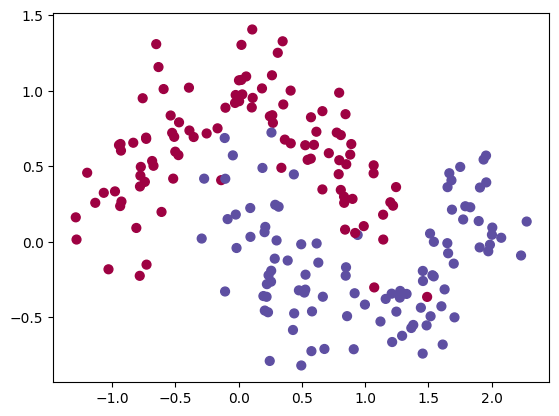

In [5]:
X,y = get_dataset("noisy_moons")


In [6]:
nn = NeuralNetwork(n_l = [4,3,1], lr = 1.2, g = ["tanh", "tanh","sigmoid"],epochs = 5000)
nn.fit(X,y)


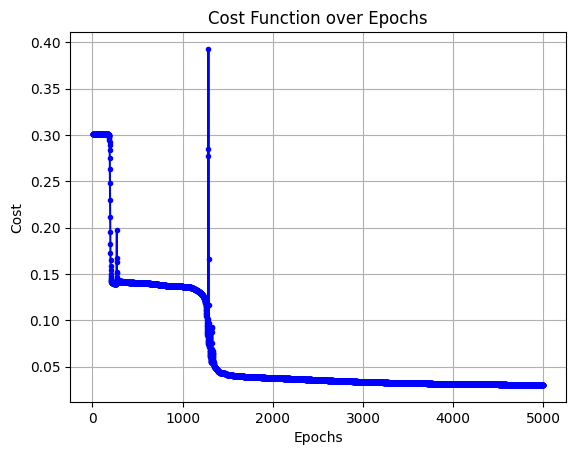

In [7]:

# Generate an array of epoch numbers
epoch_numbers = list(range(1, nn.epochs + 1))  # Create a list from 1 to 300

# Plot the cost values against epoch numbers
plt.plot(epoch_numbers, nn.cost, marker='.', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost Function over Epochs')

# Optionally add grid for better visualization
plt.grid(True)

# Show the plot
plt.show()

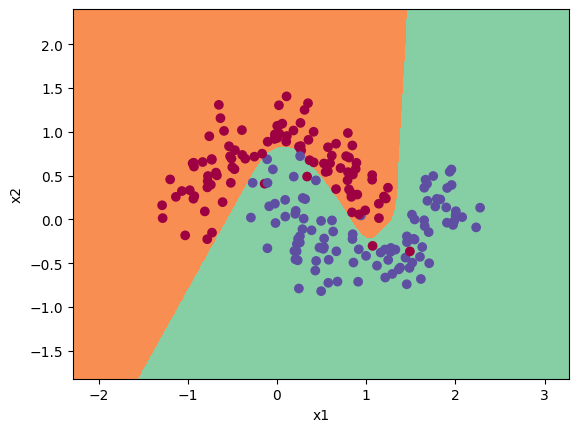

In [9]:
plot_decision_boundary(lambda x: nn.predict(x.T), X, y)

<ipython-input-10-228b46a73bd4>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)


Accuracy for noisy_circles hidden units: 77.5 %
Accuracy for noisy_moons hidden units: 97.0 %
Accuracy for blobs hidden units: 83.0 %
Accuracy for gaussian_quantiles hidden units: 97.5 %


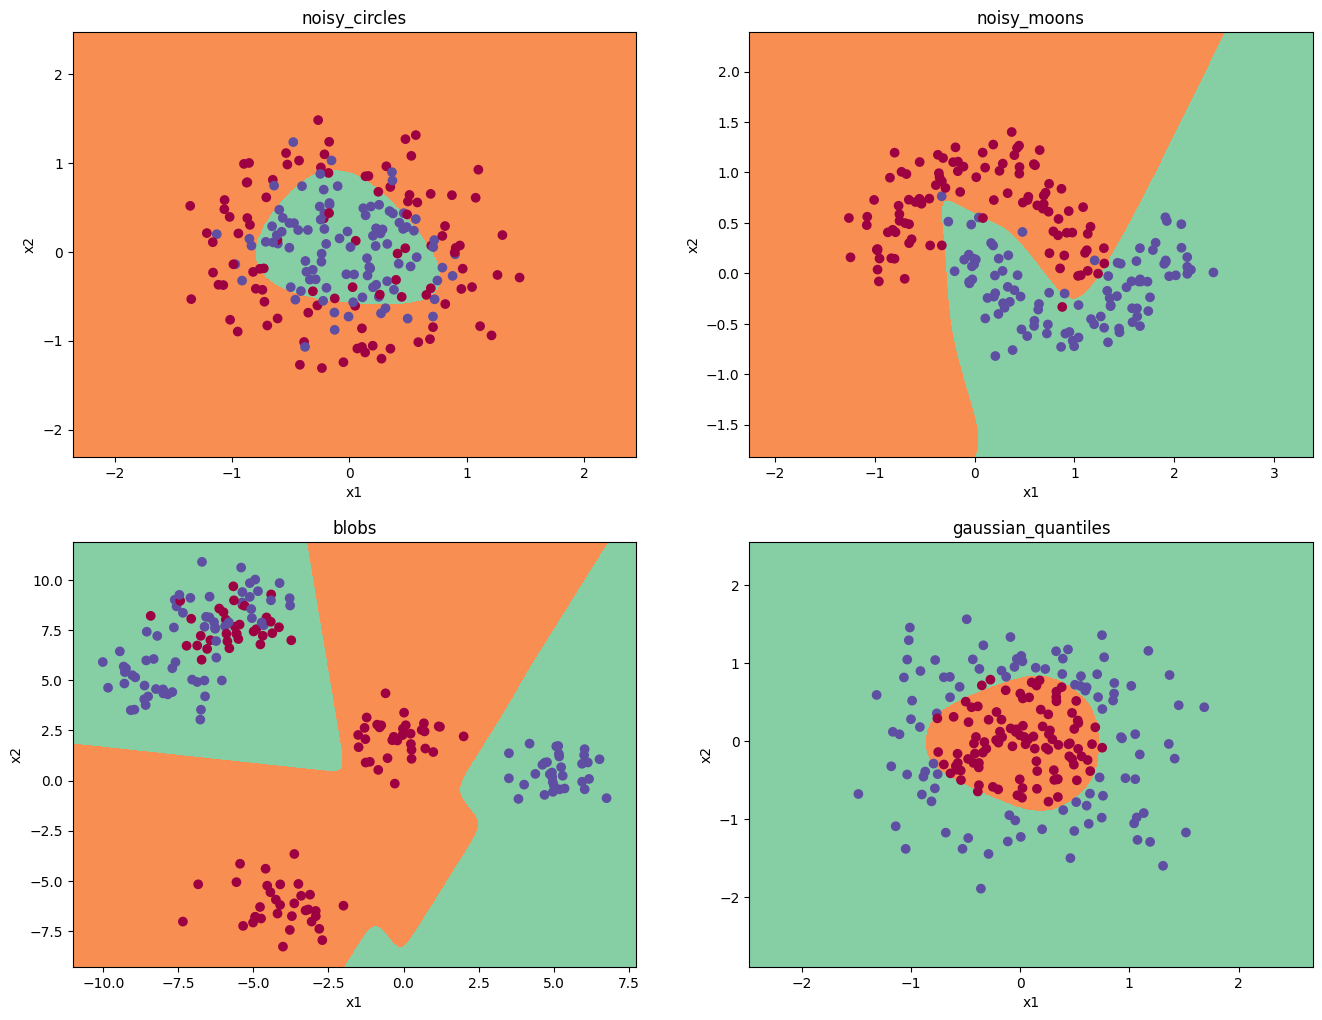

In [10]:
# for differnt datasets

# This may take about 2 minutes to run
n_h = 5 #hidden units
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
datasets = ["noisy_circles","noisy_moons", "blobs","gaussian_quantiles"]

for i in datasets:
    plt.subplot(5, 2, datasets.index(i)+1)
    plt.title(i)
    X,Y = get_dataset(i)
    nn = NeuralNetwork(n_l = [5,1], lr = 1.2, g = ["tanh","sigmoid"],epochs = 5000)
    nn.fit(X,Y)
    plot_decision_boundary(lambda x: nn.predict(x.T), X, Y)
    predictions = nn.predict(X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(i, accuracy))